In [1]:
import numpy as np
import matplotlib.pyplot as plt

import imageio
import os
import scipy
import scipy.ndimage

import nibabel as nib

base_path = "c:/Users/bsterling/Desktop/3DBioImaging/Zebrafish/"
image_dir = base_path + "mrcnn_pred/images/"
masks_dir = base_path + "mrcnn_pred/masks/"

In [2]:
def sinc_interp(x, s, u):
    """
    Interpolates x, sampled at "s" instants
    Output y is sampled at "u" instants ("u" for "upsampled")
    
    from Matlab:
    http://phaseportrait.blogspot.com/2008/06/sinc-interpolation-in-matlab.html        
    """
        
    # Find the period    
    T = s[1] - s[0]
    
    sincM = np.tile(u, (len(s), 1)) - np.tile(s[:, np.newaxis], (1, len(u)))
    y = np.dot(x, np.sinc(sincM/T))
    return y

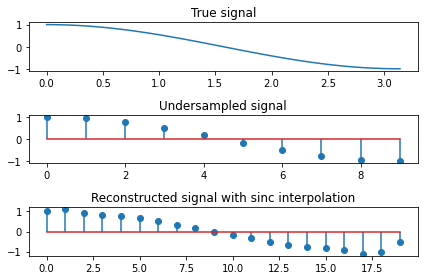

In [48]:
# 1D Example of sinc interpolation:

undersampled_signal = np.cos(np.linspace(0, np.pi, 10))
plt.subplot(311)
plt.plot(np.linspace(0, np.pi, 100), np.cos(np.linspace(0, np.pi, 100)))
plt.title("True signal")

plt.subplot(312)
plt.stem(undersampled_signal)
plt.title("Undersampled signal")

plt.subplot(313)
rescale_factor = 2
plt.stem(sinc_interp(undersampled_signal, np.arange(0, 10 * rescale_factor, rescale_factor), np.arange(0, 10 * rescale_factor, 1)))
plt.title("Reconstructed signal with sinc interpolation")

plt.tight_layout()

In [51]:
x = np.array(imageio.imread(masks_dir + "T1/1.tif"))

xlen = np.shape(x)[0]
ylen = np.shape(x)[1]
zlen = len(os.listdir(masks_dir + "T1/"))

image = np.zeros((xlen, ylen, zlen))
mask = np.zeros((xlen, ylen, zlen))

for i in range(zlen):
    image[:, :, i] = np.array(imageio.imread(image_dir + "T1/" + str(i + 1) + ".tif"))
    mask[:, :, i] = np.array(imageio.imread(masks_dir + "T1/" + str(i + 1) + ".tif"))

In [52]:
image = image * mask

In [82]:
# Perform sinc interpolation here:
rescale_factor = 2
rescaled_image = np.zeros((xlen, ylen, rescale_factor * zlen))

for i in range(xlen):
    for j in range(ylen):
        signal = sinc_interp(image[i, j, :], np.arange(0, 40 * rescale_factor, rescale_factor), np.arange(0, 40 * rescale_factor, 1))
        rescaled_image[i, j, :] = scipy.ndimage.gaussian_filter(signal, rescale_factor)

In [83]:
smoothed_image = np.round(rescaled_image / np.max(rescaled_image))
#smoothed_image = (rescaled_image / 255) > 0.5
#smoothed_image = smoothed_image.astype(int)

# Downsample image:
# smoothed_image = smoothed_image[:,:,::rescale_factor]

In [84]:
# Save image as nifti:
nib.save(nib.Nifti1Image(smoothed_image, affine=np.eye(4)), base_path + "output2x.nii.gz")

In [60]:
# Try z-smoothing original image
simple_z = np.zeros((xlen, ylen, zlen))

for i in range(xlen):
    for j in range(ylen):
        simple_z[i, j, :] = scipy.ndimage.gaussian_filter(image[i, j, :], 1)

In [61]:
# Save original image as nifti:
nib.save(nib.Nifti1Image(simple_z, affine=np.eye(4)), base_path + "original.nii.gz")